In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
df0 = pd.read_table( 'data_colorectal.txt', header=None, names=[ 'chr', 'pos', 'ref', 'alt', 'ID'], low_memory=False)
df0.chr = df0.chr.astype(str)
df0.ref = df0.ref.astype(str)
df0.alt = df0.alt.astype(str)
df0.ID = df0.ID.astype(str)

In [3]:
chrList = np.sort(df0.chr.unique())

In [4]:
hg19_chrLength = pd.read_table( 'hg19_chr_sizes.txt', header=None, names=[ 'chr', 'length'], low_memory=False)

hg19_chrLength.chr = hg19_chrLength.chr.astype(str)
# remove chr from beginning of chromosome names
hg19_chrLength.chr = hg19_chrLength.chr.str.lstrip('chr')
# remove 'Un_' and '_random'
hg19_chrLength.chr = hg19_chrLength.chr.str.lstrip('Un')
hg19_chrLength.chr = hg19_chrLength.chr.str.rstrip('_random')
# remove chromosome number from the beginning of non-regular chromosome names
for name in hg19_chrLength.chr:
    if '_gl' in name:
        x = name.find('_')
        hg19_chrLength.chr.loc[ hg19_chrLength.chr == name] = name[(x+1):] + '.1'
# make all characters uppercase
hg19_chrLength.chr = hg19_chrLength.chr.str.upper()
# change M to MT
hg19_chrLength.chr.loc[ hg19_chrLength.chr == 'M'] = 'MT'

/home/julien/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Get mean and standard deviation values for calculating p-values.

Mean and standard deviation of mutation positions are obtained for each chromosome.

In [5]:
chrSampleMean = []
chrSampleStdv = []
for name in chrList:
    chrSampleMean.append( np.mean( df0.pos[ df0.chr==name]) )
    chrSampleStdv.append(  np.std( df0.pos[ df0.chr==name]) )

chrSampleMean = pd.Series( chrSampleMean, index=chrList)
chrSampleStdv = pd.Series( chrSampleStdv, index=chrList)

In [6]:
chrSampleSize = []
for name in chrList:
    chrSampleSize.append( len( df0[ df0.chr==name]))

chrSampleSize = pd.Series( chrSampleSize, index=chrList)

In [7]:
df1 = pd.concat( [ chrSampleMean, chrSampleStdv, chrSampleSize], axis=1)
df1.columns = [ 'dataM', 'dataS', 'dataSize']
df1 = pd.merge( df1, hg19_chrLength.set_index('chr'), left_index=True, right_index=True)
print df1.shape

(76, 4)


Calculate the null hypothesis mean and standard deviation.
The null hypothesis is that the mutations are uniformly distributed across each chromosome.

In [8]:
df1['nullM'] = df1.length / 2.0
df1['nullS'] = df1.length / 3.464

Import the necessary scipy function to calculate t tests and p-values.

In [9]:
from scipy.stats import ttest_1samp

In [10]:
ttest = pd.Series( [ 0.0 for name in chrList], index=chrList)
pvals = pd.Series( [ 0.0 for name in chrList], index=chrList)

for name in chrList:
    ttest[name], pvals[name] = ttest_1samp( df0.pos[ df0.chr==name], df1.nullM[name])

/home/julien/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/julien/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


This outputs an error because chromosome GL000248.1 only has a single mutation and therefore the t-test fails because in this case the standard deviation is zero.

Lets combine the results into one data table.

In [11]:
df1 = pd.concat( [ df1, ttest, pvals], axis=1)
df1.columns = [ 'dataM', 'dataS', 'dataSize', 'length', 'nullM', 'nullS', 't', 'p']
df1.head()

,dataM,dataS,dataSize,length,nullM,nullS,t,p
1,1.245440e+08,7.637616e+07,73928,249250621,124625310.5,7.195457e+07,-0.289504,7.721966e-01
10,6.756364e+07,4.017361e+07,44639,135534747,67767373.5,3.912666e+07,-1.071463,2.839673e-01
11,6.751503e+07,3.913691e+07,44030,135006516,67503258.0,3.897417e+07,0.063092,9.496937e-01
12,6.864880e+07,3.943246e+07,42947,133851895,66925947.5,3.864085e+07,9.054329,1.430215e-19
13,6.800756e+07,2.688929e+07,35680,115169878,57584939.0,3.324766e+07,73.215664,0.000000e+00


Let's take a look at the chromosomes with the smallest p-values.

In [12]:
n=10
df1.p.sort_values()[6:(6+n)]

5             4.592902e-71
9             5.338077e-26
20            1.334393e-24
12            1.430215e-19
18            2.883281e-19
X             3.268436e-18
3             3.862463e-12
GL000237.1    4.589091e-10
GL000220.1    2.896094e-08
2             4.759265e-08
Name: p, dtype: float64

There are a couple of irregular chromosomes with small p-values. We will remove these and focus our analysis solely on regular chromosomes.

In [13]:
chrRegList = []
for i in range(22):
    chrRegList.append( str(i+1))
chrRegList.append('X')
chrRegList.append('Y')

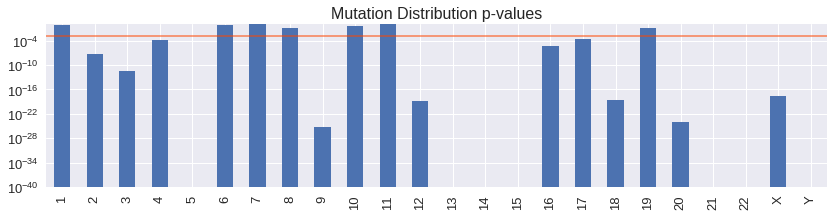

In [14]:
y = df1.loc[ chrRegList].p
xlab = [ u for u in y.index]

plt.figure( figsize=(14,3))
plt.axhline( y=0.001, color='orangered', linewidth=2, alpha=0.5)
y.plot( kind='bar')

fs = 16;
plt.title('Mutation Distribution p-values', fontsize=fs)
plt.xticks( range(len(y)), xlab, rotation=90, fontsize=fs-3);
plt.yticks( fontsize=fs-3)
plt.ylim([10**-40,10**0]);
plt.yscale('log')
# plt.savefig('p_value_1.png', dpi=100)

Chromosomes with large p-values (bars higher than the orange line) are likely to have their muations uniformly distributed across the entire chromosome. Chromosomes with small p-values are likely to have mutations distributed non-uniformly.

Regions of highly concentrated mutations within a chromosome may be an indicator of cancer-driven mutations.

## Visualizing  Mutation Distributions

In [15]:
dfNorm = pd.merge( df0, hg19_chrLength, on='chr')
dfNorm['relPos'] = (dfNorm.pos / dfNorm.length)

In [16]:
hist = [ [] for name in chrList]
bin_edge = [ [] for name in chrList]

for i, name in enumerate( chrList):
    hist[i], bin_edge[i] = np.histogram( dfNorm.relPos[ dfNorm.chr==name], bins=10, range=( 0., 1.), density=True)

In [17]:
# List of the chromosomes with the smallest and largest non-zeros p-values.
pMin = [ '5', '9', '20']
pMax = [ '11', '7', '1']

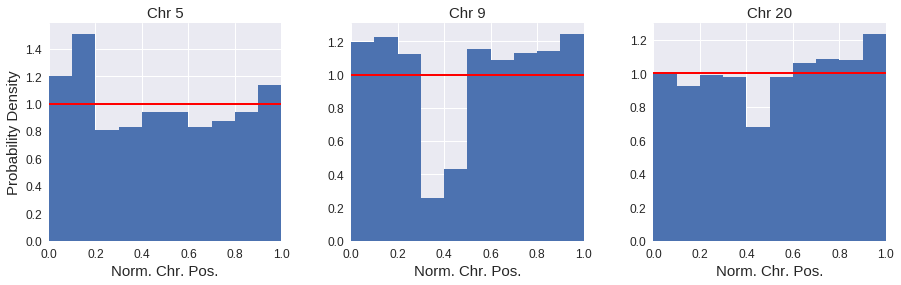

In [20]:
fs = 15

plt.figure( figsize=(15,4))
plt.subplots_adjust( hspace=0.2, wspace=0.3)

for i, name in enumerate( pMin):
    plt.subplot( 1, 3, i+1)
    iSubFig = chrList.tolist().index(name)
    plt.bar(bin_edge[iSubFig][:-1], hist[iSubFig], width=0.1, align='edge')
    plt.axhline( y=1.0, color='red', linewidth=2.0)
    plt.xlim([0,1]);
    plt.xticks( fontsize=fs-3);
    plt.yticks( fontsize=fs-3);
    plt.xlabel('Norm. Chr. Pos.', fontsize=fs)
    ts = 'Chr '+chrList[iSubFig]
    plt.title( ts, fontsize=fs)
    if i == 0:
        plt.ylabel('Probability Density', fontsize=fs)

# plt.savefig('p_value_min.png', dpi=100)

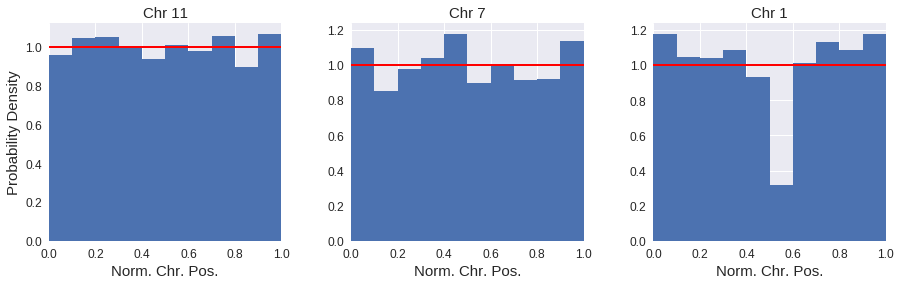

In [21]:
fs = 15

plt.figure( figsize=(15,4))
plt.subplots_adjust( hspace=0.2, wspace=0.3)

for i, name in enumerate( pMax):
    plt.subplot( 1, 3, i+1)
    iSubFig = chrList.tolist().index(name)
    plt.bar(bin_edge[iSubFig][:-1], hist[iSubFig], width=0.1, align='edge')
    plt.axhline( y=1.0, color='red', linewidth=2.0)
    plt.xlim([0,1]);
    plt.xticks( fontsize=fs-3);
    plt.yticks( fontsize=fs-3);
    plt.xlabel('Norm. Chr. Pos.', fontsize=fs)
    ts = 'Chr '+chrList[iSubFig]
    plt.title( ts, fontsize=fs)
    if i == 0:
        plt.ylabel('Probability Density', fontsize=fs)

# plt.savefig('p_value_max.png', dpi=100)